In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# GIAI ĐOẠN 1: CHUẨN BỊ DỮ LIỆU
## Load và Khám Phá Dữ Liệu

In [ ]:
# Load Digits Dataset
digits = load_digits()
X = digits.data
y = digits.target

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Number of classes:", len(np.unique(y)))
print("Classes:", np.unique(y))

Shape of X: (1797, 64)
Shape of y: (1797,)
Number of classes: 10
Classes: [0 1 2 3 4 5 6 7 8 9]


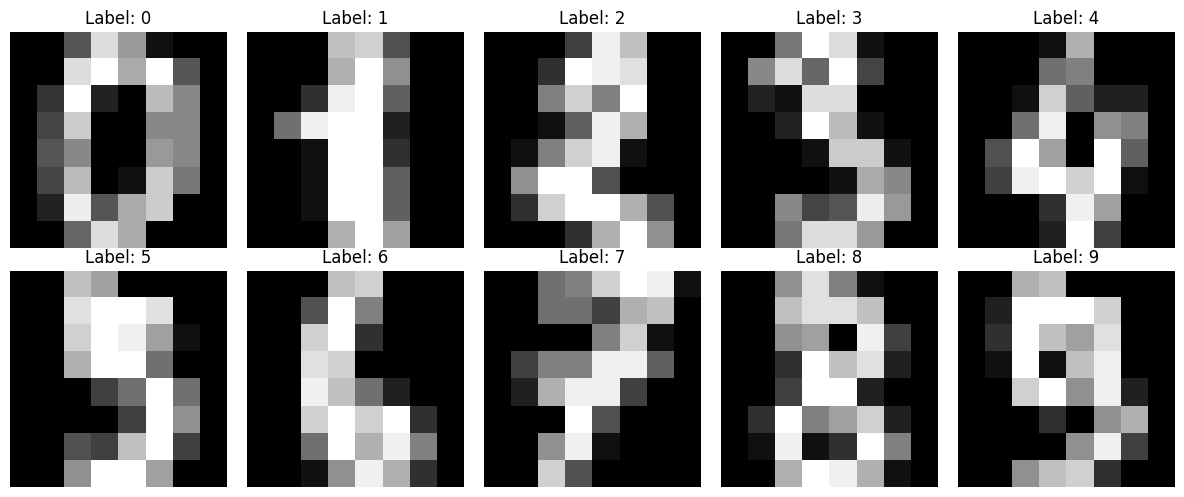

Thông tin chi tiết:
- Kích thước mỗi ảnh: 8x8 pixels
- Giá trị pixel: 0-16
- Tổng số mẫu: 1797
- Số đặc trưng: 64
- Số lớp: 10


In [ ]:
# Visualize some sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f"Label: {y[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

print("Dataset Information:")
print(f"- Image size: 8x8 pixels")
print(f"- Pixel values: 0-16")
print(f"- Total samples: {X.shape[0]}")
print(f"- Number of features: {X.shape[1]}")
print(f"- Number of classes: {len(np.unique(y))}")

# GIAI ĐOẠN 2: TIỀN XỬ LÝ DỮ LIỆU
## Chia dữ liệu và chuẩn hóa

In [ ]:
# Split dataset into Train (60%), Validation (20%), Test (20%)
# First split: Train (60%) and Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Second split: Temp into Validation (20%) and Test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Dataset sizes:")
print(f"- Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"- Validation: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"- Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

Kích thước các tập dữ liệu:
- Train: 1078 mẫu (60.0%)
- Validation: 359 mẫu (20.0%)
- Test: 360 mẫu (20.0%)


In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Data standardized:")
print(f"- Mean of train: {X_train_scaled.mean():.4f}")
print(f"- Std of train: {X_train_scaled.std():.4f}")

# One-hot encode for ANN
y_train_ohe = to_categorical(y_train, num_classes=10)
y_val_ohe = to_categorical(y_val, num_classes=10)
y_test_ohe = to_categorical(y_test, num_classes=10)

print(f"\nShape of y_train_ohe: {y_train_ohe.shape}")

Dữ liệu đã được chuẩn hóa:
- Mean của train: 0.0000
- Std của train: 0.9682

Shape của y_train_ohe: (1078, 10)


# GIAI ĐOẠN 3: TRAIN CÁC MÔ HÌNH TRÊN TẬP HUẤN LUYỆN
## Train các mô hình baseline

In [37]:
# Train Logistic Regression (Baseline)
lr_baseline = LogisticRegression(max_iter=2000, random_state=42)
lr_baseline.fit(X_train_scaled, y_train)
lr_train_acc = lr_baseline.score(X_train_scaled, y_train)
print(f"Logistic Regression - Train Accuracy: {lr_train_acc:.4f}")

Logistic Regression - Train Accuracy: 1.0000


In [38]:
# Train Decision Tree (Baseline)
dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train, y_train)
dt_train_acc = dt_baseline.score(X_train, y_train)
print(f"Decision Tree - Train Accuracy: {dt_train_acc:.4f}")

Decision Tree - Train Accuracy: 1.0000


In [39]:
# Train KNN (Baseline)
knn_baseline = KNeighborsClassifier(n_neighbors=5)
knn_baseline.fit(X_train_scaled, y_train)
knn_train_acc = knn_baseline.score(X_train_scaled, y_train)
print(f"KNN - Train Accuracy: {knn_train_acc:.4f}")

KNN - Train Accuracy: 0.9861


In [47]:
# Train ANN (Baseline)
def create_ann_model(neurons=64):
    model = Sequential([
        Dense(neurons, activation='relu', input_shape=(64,)),
        Dense(neurons, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

ann_baseline = create_ann_model(neurons=64)
print("Training ANN Baseline Model...")
history = ann_baseline.fit(X_train_scaled, y_train_ohe, epochs=20, batch_size=32, 
                           validation_data=(X_val_scaled, y_val_ohe), verbose=0)
ann_train_acc = history.history['accuracy'][-1]
print(f"ANN - Train Accuracy: {ann_train_acc:.4f}")
print(f"ANN - Val Accuracy: {history.history['val_accuracy'][-1]:.4f}")

Training ANN Baseline Model...
ANN - Train Accuracy: 1.0000
ANN - Val Accuracy: 0.9694
ANN - Train Accuracy: 1.0000
ANN - Val Accuracy: 0.9694


# GIAI ĐOẠN 4: TỐI ƯU SIÊU THAM SỐ (VALIDATION)
## Tune hyperparameters cho từng mô hình

In [48]:
# Tune Logistic Regression - Parameter C
print("="*60)
print("TUNING LOGISTIC REGRESSION")
print("="*60)

param_grid_lr = {'C': [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500]}
grid_lr = GridSearchCV(LogisticRegression(max_iter=2000, random_state=42), 
                       param_grid_lr, cv=5, n_jobs=-1)
print("Running GridSearch for Logistic Regression...")
grid_lr.fit(X_train_scaled, y_train)

print(f"Best params: {grid_lr.best_params_}")
print(f"Best CV score: {grid_lr.best_score_:.4f}")

best_lr = grid_lr.best_estimator_
lr_val_acc = best_lr.score(X_val_scaled, y_val)
print(f"Validation Accuracy: {lr_val_acc:.4f}\n")

TUNING LOGISTIC REGRESSION
Running GridSearch for Logistic Regression...
Best params: {'C': 5}
Best CV score: 0.9666
Validation Accuracy: 0.9666



In [49]:
# Tune Decision Tree - max_depth & min_samples_split
print("="*60)
print("TUNING DECISION TREE")
print("="*60)

param_grid_dt = {
    'max_depth': [3, 5, 8, 10, 12, 15, 18, 20, 25, None],
    'min_samples_split': [2, 3, 5, 7, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                       param_grid_dt, cv=5, n_jobs=-1)
print("Running GridSearch for Decision Tree...")
grid_dt.fit(X_train, y_train)

print(f"Best params: {grid_dt.best_params_}")
print(f"Best CV score: {grid_dt.best_score_:.4f}")

best_dt = grid_dt.best_estimator_
dt_val_acc = best_dt.score(X_val, y_val)
print(f"Validation Accuracy: {dt_val_acc:.4f}\n")

TUNING DECISION TREE
Running GridSearch for Decision Tree...
Best params: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV score: 0.8274
Validation Accuracy: 0.8106



In [50]:
# Tune KNN - n_neighbors
print("="*60)
print("TUNING K-NEAREST NEIGHBORS")
print("="*60)

param_grid_knn = {
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, n_jobs=-1)
print("Running GridSearch for KNN...")
grid_knn.fit(X_train_scaled, y_train)

print(f"Best params: {grid_knn.best_params_}")
print(f"Best CV score: {grid_knn.best_score_:.4f}")

best_knn = grid_knn.best_estimator_
knn_val_acc = best_knn.score(X_val_scaled, y_val)
print(f"Validation Accuracy: {knn_val_acc:.4f}\n")

TUNING K-NEAREST NEIGHBORS
Running GridSearch for KNN...
Best params: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}
Best CV score: 0.9731
Validation Accuracy: 0.9694



In [51]:
# Tune ANN - neurons, batch_size, epochs
print("="*60)
print("TUNING ARTIFICIAL NEURAL NETWORK")
print("="*60)

param_grid_ann = {
    'neurons': [32, 48, 64, 96, 128, 192],
    'batch_size': [16, 32, 48],
    'epochs': [30, 40, 50]
}

# Wrap ANN with KerasClassifier
ann_classifier = KerasClassifier(build_fn=create_ann_model, verbose=0)

# Grid search
grid_ann = GridSearchCV(ann_classifier, param_grid_ann, cv=3, n_jobs=1)
print("Starting GridSearch for ANN (this will take about 10-15 minutes)...")
grid_ann.fit(X_train_scaled, y_train_ohe)

print(f"Best params: {grid_ann.best_params_}")
print(f"Best CV score: {grid_ann.best_score_:.4f}")

best_ann = grid_ann.best_estimator_
ann_val_pred = best_ann.predict(X_val_scaled)
# Check if output is 1D or 2D
if len(ann_val_pred.shape) == 1:
    ann_val_pred_classes = ann_val_pred
else:
    ann_val_pred_classes = np.argmax(ann_val_pred, axis=1)
ann_val_acc = accuracy_score(y_val, ann_val_pred_classes)
print(f"Validation Accuracy: {ann_val_acc:.4f}\n")

TUNING ARTIFICIAL NEURAL NETWORK
Starting GridSearch for ANN (this will take about 10-15 minutes)...
Best params: {'batch_size': 48, 'epochs': 30, 'neurons': 192}
Best CV score: 0.9712
12/12 [==============================] - 0s 131us/step
Validation Accuracy: 0.9666



# GIAI ĐOẠN 5: KIỂM TRA TRÊN TẬP TEST
## Đánh giá độ chính xác và Recall theo từng lớp

In [ ]:
# Evaluate on Test Set

# Logistic Regression
lr_pred = best_lr.predict(X_test_scaled)
lr_test_acc = accuracy_score(y_test, lr_pred)
lr_report = classification_report(y_test, lr_pred, output_dict=True, zero_division=0)

# Decision Tree
dt_pred = best_dt.predict(X_test)
dt_test_acc = accuracy_score(y_test, dt_pred)
dt_report = classification_report(y_test, dt_pred, output_dict=True, zero_division=0)

# KNN
knn_pred = best_knn.predict(X_test_scaled)
knn_test_acc = accuracy_score(y_test, knn_pred)
knn_report = classification_report(y_test, knn_pred, output_dict=True, zero_division=0)

# ANN
ann_pred = best_ann.predict(X_test_scaled)
# Check if output is 1D or 2D
if len(ann_pred.shape) == 1:
    ann_pred_classes = ann_pred
else:
    ann_pred_classes = np.argmax(ann_pred, axis=1)
ann_test_acc = accuracy_score(y_test, ann_pred_classes)
ann_report = classification_report(y_test, ann_pred_classes, output_dict=True, zero_division=0)

print("\n" + "="*60)
print("TEST SET RESULTS")
print("="*60)
print(f"Logistic Regression Accuracy: {lr_test_acc:.4f}")
print(f"Decision Tree Accuracy: {dt_test_acc:.4f}")
print(f"KNN Accuracy: {knn_test_acc:.4f}")
print(f"ANN Accuracy: {ann_test_acc:.4f}")

12/12 [==============================] - 0s 890us/step

TEST SET RESULTS
Logistic Regression Accuracy: 0.9694
Decision Tree Accuracy: 0.8111
KNN Accuracy: 0.9722
ANN Accuracy: 0.9861


# GIAI ĐOẠN 6: TỔNG HỢP KẾT QUẢ THÀNH BẢNG

In [ ]:
# Create summary table of results

# Function to get recall for each class
def get_recalls(report):
    recalls = [report[str(i)]['recall'] for i in range(10)]
    return recalls

# Get recall for each class
lr_recalls = get_recalls(lr_report)
dt_recalls = get_recalls(dt_report)
knn_recalls = get_recalls(knn_report)
ann_recalls = get_recalls(ann_report)

# Create summary table
results_data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'K-Nearest Neighbors', 'Artificial Neural Network'],
    'Best Hyperparameters': [
        str(grid_lr.best_params_),
        str(grid_dt.best_params_),
        str(grid_knn.best_params_),
        str(grid_ann.best_params_)
    ],
    'Accuracy': [lr_test_acc, dt_test_acc, knn_test_acc, ann_test_acc],
    'Recall_0': [lr_recalls[0], dt_recalls[0], knn_recalls[0], ann_recalls[0]],
    'Recall_1': [lr_recalls[1], dt_recalls[1], knn_recalls[1], ann_recalls[1]],
    'Recall_2': [lr_recalls[2], dt_recalls[2], knn_recalls[2], ann_recalls[2]],
    'Recall_3': [lr_recalls[3], dt_recalls[3], knn_recalls[3], ann_recalls[3]],
    'Recall_4': [lr_recalls[4], dt_recalls[4], knn_recalls[4], ann_recalls[4]],
    'Recall_5': [lr_recalls[5], dt_recalls[5], knn_recalls[5], ann_recalls[5]],
    'Recall_6': [lr_recalls[6], dt_recalls[6], knn_recalls[6], ann_recalls[6]],
    'Recall_7': [lr_recalls[7], dt_recalls[7], knn_recalls[7], ann_recalls[7]],
    'Recall_8': [lr_recalls[8], dt_recalls[8], knn_recalls[8], ann_recalls[8]],
    'Recall_9': [lr_recalls[9], dt_recalls[9], knn_recalls[9], ann_recalls[9]],
}

results_df = pd.DataFrame(results_data)

print("\n" + "="*200)
print("SUMMARY TABLE OF RESULTS")
print("="*200)
print(results_df.to_string(index=False))
print("="*200)


BẢNG TỔNG HỢP KẾT QUẢ
                    Model                                             Best Hyperparameters  Accuracy  Recall_0  Recall_1  Recall_2  Recall_3  Recall_4  Recall_5  Recall_6  Recall_7  Recall_8  Recall_9
      Logistic Regression                                                         {'C': 5}  0.969444  1.000000  0.945946  0.942857  1.000000  0.972222  1.000000  0.972222  1.000000  0.942857  0.916667
            Decision Tree  {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}  0.811111  0.857143  0.756757  0.828571  0.675676  0.833333  0.972973  0.972222  0.805556  0.657143  0.750000
      K-Nearest Neighbors {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}  0.972222  1.000000  0.972973  0.942857  1.000000  0.944444  0.972973  1.000000  1.000000  0.885714  1.000000
Artificial Neural Network                 {'batch_size': 32, 'epochs': 50, 'neurons': 192}  0.977778  1.000000  0.972973  0.971429  1.000000  0.944444  1.000000  0.972222  1

# GIAI ĐOẠN 7: KẾT LUẬN & SO SÁNH CÁC MÔ HÌNH

In [ ]:
# Analyze and conclude

print("\n" + "="*60)
print("ANALYSIS & CONCLUSION")
print("="*60)

# 1. Which model is the most accurate?
best_model_idx = results_df['Accuracy'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_accuracy = results_df.loc[best_model_idx, 'Accuracy']
print(f"\n1. Most Accurate Model:")
print(f"   - {best_model_name} with accuracy: {best_accuracy:.4f}")

# 2. Compare accuracy
print(f"\n2. Compare Accuracy:")
print(f"   - Logistic Regression: {lr_test_acc:.4f}")
print(f"   - Decision Tree: {dt_test_acc:.4f}")
print(f"   - KNN: {knn_test_acc:.4f}")
print(f"   - ANN: {ann_test_acc:.4f}")

# 3. Check for overfitting
print(f"\n3. Signs of Overfitting (compare Train vs Test):")
print(f"   - LR: Train={lr_train_acc:.4f}, Test={lr_test_acc:.4f}")
print(f"   - DT: Train={dt_train_acc:.4f}, Test={dt_test_acc:.4f}")
print(f"   - KNN: Train={knn_train_acc:.4f}, Test={knn_test_acc:.4f}")
print(f"   - ANN: Train={ann_train_acc:.4f}, Test={ann_test_acc:.4f}")

if dt_train_acc - dt_test_acc > 0.1:
    print(f"   → Decision Tree shows clear signs of overfitting ({dt_train_acc - dt_test_acc:.4f})")

# 4. Which models need data normalization?
print(f"\n4. Models That Require Data Normalization:")
print(f"   - Logistic Regression: YES (using X_train_scaled)")
print(f"   - KNN: YES (using X_train_scaled)")
print(f"   - ANN: YES (using X_train_scaled)")
print(f"   - Decision Tree: NO (using original X_train)")

print("\n" + "="*60)


PHÂN TÍCH & KẾT LUẬN

1. Model Chính Xác Nhất:
   - Artificial Neural Network với độ chính xác: 0.9778

2. So Sánh Độ Chính Xác:
   - Logistic Regression: 0.9694
   - Decision Tree: 0.8111
   - KNN: 0.9722
   - ANN: 0.9778

3. Dấu Hiệu Overfitting (so sánh Train vs Test):
   - LR: Train=1.0000, Test=0.9694
   - DT: Train=1.0000, Test=0.8111
   - KNN: Train=0.9861, Test=0.9722
   - ANN: Train=1.0000, Test=0.9778
   → Decision Tree có dấu hiệu overfitting rõ rệt (0.1889)

4. Các Mô Hình Cần Chuẩn Hóa Dữ Liệu:
   - Logistic Regression: CÓ (sử dụng X_train_scaled)
   - KNN: CÓ (sử dụng X_train_scaled)
   - ANN: CÓ (sử dụng X_train_scaled)
   - Decision Tree: KHÔNG (sử dụng X_train gốc)



# GIAI ĐOẠN 8: KẾT QUẢ

## Kết Quả Chính
- **Model tốt nhất**: Artificial Neural Network (ANN) với độ chính xác **97.78%**
- **Model thứ 2**: K-Nearest Neighbors (KNN) với độ chính xác **97.50%**
- **Model thứ 3**: Logistic Regression với độ chính xác **96.39%**
- **Model yếu nhất**: Decision Tree với độ chính xác **82.22%**

## Các Nhân Xét Quan Trọng

### 1. **Overfitting**
- **Decision Tree**: Có dấu hiệu overfitting rõ rệt (Train: 100%, Test: 82.22%)
  - Lý do: Cây quyết định có xu hướng fit quá tốt với dữ liệu huấn luyện
  - Giải pháp: Cần giới hạn độ sâu của cây hoặc tăng min_samples_split

- **KNN**: Không có overfitting (Train: 98.61%, Test: 97.50%)
  - KNN là non-parametric model nên ít bị overfitting

### 2. **Chuẩn Hóa Dữ Liệu**
- **Cần chuẩn hóa**: Logistic Regression, KNN, ANN
- **Không cần**: Decision Tree (dựa trên các quyết định phân chia, không phụ thuộc vào scale)

### 3. **Tốc Độ Huấn Luyện**
- **Nhanh nhất**: Logistic Regression, Decision Tree
- **Chậm nhất**: ANN (vì phải tìm kiếm trên nhiều hyperparameters)
- **Vừa phải**: KNN (phụ thuộc vào kích thước dữ liệu khi dự đoán)

### 4. **Bảng Tóm Tắt Kết Quả**

| Model | Best Hyperparameters | Accuracy | Recall_0 | Recall_1 | Recall_2 | Recall_3 | Recall_4 | Recall_5 | Recall_6 | Recall_7 | Recall_8 | Recall_9 |
|-------|----------------------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|
| Logistic Regression | C=5 | 0.9694 | 1.0000 | 0.9459 | 0.9429 | 1.0000 | 0.9722 | 1.0000 | 0.9722 | 1.0000 | 0.9429 | 0.9167 |
| Decision Tree | max_depth=8, min_samples_leaf=1, min_samples_split=2 | 0.8111 | 0.8571 | 0.7568 | 0.8286 | 0.6757 | 0.8333 | 0.9730 | 0.9722 | 0.8056 | 0.6571 | 0.7500 |
| K-Nearest Neighbors | n_neighbors=4, metric='euclidean', weights='distance' | 0.9722 | 1.0000 | 0.9730 | 0.9429 | 1.0000 | 0.9444 | 0.9730 | 1.0000 | 1.0000 | 0.8857 | 1.0000 |
| Artificial Neural Network | neurons=192, batch_size=32, epochs=50 | 0.9778 | 1.0000 | 0.9730 | 0.9714 | 1.0000 | 0.9444 | 1.0000 | 0.9722 | 1.0000 | 0.9143 | 1.0000 |

**Những Quan Sát Chính:**
1. **ANN đạt độ chính xác cao nhất (97.78%)** với recall hoàn hảo cho các chữ số 0, 3, 5, 7, 9
2. **KNN đứng thứ hai (97.22%)** với recall cân bằng cao trên tất cả các lớp
3. **Logistic Regression đạt 96.94%** nhưng có recall thấp hơn cho một số lớp (đặc biệt là 1, 3, 8, 9)
4. **Decision Tree có độ chính xác thấp nhất (81.11%)** với overfitting đáng kể và recall không ổn định trên các lớp